<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>INTENT CLASSIFICATION</h2>

</div>

# Importing Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import nltk
import gensim
import re
import os
import string
import torch
import joblib
import sys
import random
import warnings
warnings.filterwarnings("ignore")

from transformers import BertConfig, AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve
from yellowbrick.classifier import ROCAUC
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.models import Word2Vec

from collections import Counter
from tqdm import tqdm
from pprint import pprint
from configparser import ConfigParser

## Reading JSON files from hardcoded file paths

In [2]:
#train_path = 'Project Datasets/intent classification/is_train.json'
#val_path = 'Project Datasets/intent classification/is_val.json'
#test_path = 'Project Datasets/intent classification/is_test.json'

In [4]:
#train = json.load(open(train_path,'r'))
#val   = json.load(open(val_path,'r'))
#test  = json.load(open(test_path,'r'))

In [ ]:
#train = json.load(open(train_path,'r'))
#val   = json.load(open(val_path,'r'))
#test  = json.load(open(test_path,'r'))

## Reading JSON files from Config File

In [2]:
# Reading Config file
file   = "config.ini"
config = ConfigParser()
config.read(file,encoding='utf-8')

['config.ini']

In [3]:
filepaths = dict(config.items('FilePaths'))

In [4]:
# Reading train json file
train = json.load(open(filepaths['train_path'], 'r'))

# Reading validation json file
val   = json.load(open(filepaths['val_path'], 'r'))

# Reading test json file
test  = json.load(open(filepaths['test_path'], 'r'))

In [5]:
len(val)

3000

In [6]:
len(test)

4500

In [7]:
len(train)

15000

In [8]:
# Function to iterate through json files and create dataframes
def createDataframe(json_var):
    tempList = []
    for item in json_var:
        tempList.append({'text':item[0], 'intent':item[1]})
    tempdf = pd.DataFrame(tempList)
    return tempdf

In [9]:
train_df = createDataframe(train)
test_df  = createDataframe(test)
val_df   = createDataframe(val)

In [10]:
train_df

text         intent
0      what expression would i use to say i love you ...      translate
1      can you tell me how to say 'i do not speak muc...      translate
2      what is the equivalent of, 'life is good' in f...      translate
3      tell me how to say, 'it is a beautiful morning...      translate
4      if i were mongolian, how would i say that i am...      translate
...                                                  ...            ...
14995           can you explain why my card was declined  card_declined
14996  how come starbucks declined my card when i tri...  card_declined
14997        how come my card was not accepted yesterday  card_declined
14998  find out what happened to make my card get dec...  card_declined
14999                why was my card declined at safeway  card_declined

[15000 rows x 2 columns]

# EDA

In [11]:
train_df.intent.value_counts()

translate          100
order_status       100
goodbye            100
account_blocked    100
what_song          100
                  ... 
reminder           100
change_speed       100
tire_pressure      100
no                 100
card_declined      100
Name: intent, Length: 150, dtype: int64

In [12]:
train_df.intent.nunique()

150

#### Train dataframe contains 150 intents, with each intent having 100 occurrences.

In [13]:
val_df.intent.value_counts()

translate          20
order_status       20
goodbye            20
account_blocked    20
what_song          20
                   ..
reminder           20
change_speed       20
tire_pressure      20
no                 20
card_declined      20
Name: intent, Length: 150, dtype: int64

#### Validation dataframe contains 150 intents, with each intent having 20 occurrences.

In [14]:
test_df.intent.value_counts()

translate          30
order_status       30
goodbye            30
account_blocked    30
what_song          30
                   ..
reminder           30
change_speed       30
tire_pressure      30
no                 30
card_declined      30
Name: intent, Length: 150, dtype: int64

#### Test dataframe contains 150 intents, with each intent having 30 occurrences.

### CHECKING IF DATA HAS EMAILS, URLs, MENTIONS and HASHTAGS IN THEM

In [15]:
# Checking if any text from any of the files (train, test, val) has email, url, mention and hashtags
def ngrams_top(corpus,ngram_range,n=10):
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

def get_emails(x):
    email = re.findall(r'[\w\.-]+@[\w-]+\.[\w]+',str(x))
    return " ".join(email)
def get_urls(x):
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+\.[\w]+',str(x))
    return " ".join(url)
def get_mentions(x):
    mention = re.findall(r'(?<=@)\w+',str(x))
    return " ".join(mention)
def get_hashtags(x):
    hashtag = re.findall(r'(?<=#)\w+',str(x))
    return " ".join(hashtag)
def text_at_a_glance(df):
    res = df.apply(get_emails)
    res = res[res.values!=""]
    print("Data has {} rows with emails".format(len(res)))
    res = df.apply(get_urls)
    res = res[res.values!=""]
    print("Data has {} rows with urls".format(len(res)))
    res = df.apply(get_mentions)
    res = res[res.values!=""]
    print("Data has {} rows with mentions".format(len(res)))
    res = df.apply(get_hashtags)
    res = res[res.values!=""]
    print("Data has {} rows with hashtags".format(len(res)))

In [16]:
train_df.text

0        what expression would i use to say i love you ...
1        can you tell me how to say 'i do not speak muc...
2        what is the equivalent of, 'life is good' in f...
3        tell me how to say, 'it is a beautiful morning...
4        if i were mongolian, how would i say that i am...
                               ...                        
14995             can you explain why my card was declined
14996    how come starbucks declined my card when i tri...
14997          how come my card was not accepted yesterday
14998    find out what happened to make my card get dec...
14999                  why was my card declined at safeway
Name: text, Length: 15000, dtype: object

In [17]:
text_at_a_glance(train_df.text)

Data has 0 rows with emails
Data has 0 rows with urls
Data has 0 rows with mentions
Data has 1 rows with hashtags


In [18]:
# Checking where the hashtag is present in the train set, punctuations will be taken care of by vectorizer
temp = train_df.text.apply(get_hashtags)
train_df.iloc[temp[temp.values!=""].index].text

13644    put mambo #5 by lou bega on my playlist, please
Name: text, dtype: object

In [19]:
text_at_a_glance(val_df.text)

Data has 0 rows with emails
Data has 0 rows with urls
Data has 0 rows with mentions
Data has 0 rows with hashtags


In [20]:
text_at_a_glance(test_df.text)

Data has 0 rows with emails
Data has 0 rows with urls
Data has 0 rows with mentions
Data has 0 rows with hashtags


In [21]:
# Tokenization
train_df['tokenized_text'] = train_df['text'].apply(nltk.tokenize.word_tokenize)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. LINGUISTIC ANALYSIS</h2>

</div>

### 1. WORD FREQUENCIES

#### DATA PRE-PROCESSING ON TRAIN SET

In [22]:
# Removing punctuations from the column 'text' and text lowercase conversion
train_df['cleaned_text'] = train_df['text'].apply(lambda i :"".join(t.lower() for t in i  if t not in string.punctuation))

In [23]:
# Cleaned text tokenization
train_df['cleaned_tokenized_text'] = train_df['cleaned_text'].apply(nltk.tokenize.word_tokenize)

In [24]:
# Loading all english stopwords into a set
en_stops = set(stopwords.words('english'))

In [25]:
# Removing stopwords from cleaned tokens
train_df['cleaned_tokenized_text'] = train_df['cleaned_tokenized_text'].apply(lambda x: [i for i in x if i not in en_stops])

In [26]:
# Calculating word frequencies
words = []
for each in train_df.cleaned_tokenized_text:
    words.extend(each)
word_freq = Counter(words)

In [27]:
# Sorting the counter variable in descending order of counts
sorted_word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}

In [28]:
# Word frequencies in descending order for the whole dataframe
sorted_word_freq

{'need': 1307,
 'please': 1144,
 'card': 1137,
 'tell': 998,
 'know': 843,
 'get': 749,
 'credit': 685,
 'whats': 591,
 'account': 567,
 'list': 530,
 'car': 508,
 'want': 507,
 'like': 506,
 'would': 429,
 'change': 409,
 'new': 382,
 'bank': 379,
 'time': 376,
 'many': 360,
 'much': 352,
 'go': 351,
 'find': 349,
 'make': 336,
 'take': 315,
 'long': 315,
 'name': 307,
 'next': 305,
 'help': 304,
 'bill': 295,
 'set': 284,
 'oil': 268,
 'visa': 265,
 'use': 259,
 'im': 245,
 'reservation': 239,
 'phone': 227,
 'pay': 227,
 'call': 223,
 'shopping': 222,
 'last': 220,
 'flight': 219,
 'song': 215,
 'vacation': 212,
 'date': 207,
 'number': 207,
 'good': 206,
 'put': 203,
 'gas': 201,
 'one': 195,
 'let': 193,
 'add': 192,
 'tires': 189,
 'march': 188,
 'order': 186,
 'limit': 185,
 'current': 181,
 'days': 181,
 'check': 176,
 'could': 171,
 'travel': 169,
 'going': 167,
 'give': 165,
 'calendar': 161,
 'insurance': 160,
 'playlist': 159,
 'say': 158,
 'id': 156,
 'day': 155,
 'score':

In [29]:
# Converting all the intents to numerical encodings as part of target column in train set
train_df['Target'] = train_df.intent.astype('category').cat.codes

#### DATA PRE-PROCESSING ON VALIDATION SET

In [30]:
# Pre-processing on validation set
val_df['cleaned_text'] = val_df['text'].apply(lambda i :"".join(t.lower() for t in i  if t not in string.punctuation))
val_df['cleaned_tokenized_text'] = val_df['cleaned_text'].apply(nltk.tokenize.word_tokenize)
val_df['cleaned_tokenized_text'] = val_df['cleaned_tokenized_text'].apply(lambda x: [i for i in x if i not in en_stops])
val_df

text         intent  \
0              in spanish, meet me tomorrow is said how      translate   
1                in french, how do i say, see you later      translate   
2                      how do you say hello in japanese      translate   
3             how do i ask about the weather in chinese      translate   
4             how can i say "cancel my order" in french      translate   
...                                                 ...            ...   
2995  i was at walmart trying to buy toilet paper an...  card_declined   
2996       target declined my card and i don't know why  card_declined   
2997  do you know why my card was declined at target...  card_declined   
2998  i can't figure out why my card was declined at...  card_declined   
2999  i was just at target and they declined my card...  card_declined   

                                           cleaned_text  \
0               in spanish meet me tomorrow is said how   
1                  in french how do i say see you later   
2                      how do you say hello in japanese   
3             how do i ask about the weather in chinese   
4               how can i say cancel my order in french   
...                                                 ...   
2995  i was at walmart trying to buy toilet paper an...   
2996        target declined my card and i dont know why   
2997  do you know why my card was declined at target...   
2998  i cant figure out why my card was declined at ...   
2999  i was just at target and they declined my card...   

                                 cleaned_tokenized_text  
0                       [spanish, meet, tomorrow, said]  
1                             [french, say, see, later]  
2                                [say, hello, japanese]  
3                               [ask, weather, chinese]  
4                          [say, cancel, order, french]  
...                                                 ...  
2995  [walmart, trying, buy, toilet, paper, card, go...  
2996               [target, declined, card, dont, know]  
2997       [know, card, declined, target, cant, figure]  
2998             [cant, figure, card, declined, target]  
2999         [target, declined, card, cant, understand]  

[3000 rows x 4 columns]

In [31]:
# Converting all the intents to numerical encodings as part of target column in val set
val_df['Target'] = val_df.intent.astype('category').cat.codes

#### DATA PRE-PROCESSING ON TEST SET

In [32]:
# Pre-processing on val set
test_df['cleaned_text'] = test_df['text'].apply(lambda i :"".join(t.lower() for t in i  if t not in string.punctuation))
test_df['cleaned_tokenized_text'] = test_df['cleaned_text'].apply(nltk.tokenize.word_tokenize)
test_df['cleaned_tokenized_text'] = test_df['cleaned_tokenized_text'].apply(lambda x: [i for i in x if i not in en_stops])
test_df

text         intent  \
0                 how would you say fly in italian      translate   
1                what's the spanish word for pasta      translate   
2              how would they say butter in zambia      translate   
3                   how do you say fast in spanish      translate   
4              what's the word for trees in norway      translate   
...                                            ...            ...   
4495                why can't i use my credit card  card_declined   
4496  why won't you let me pay with my credit card  card_declined   
4497             why did i get rejected on my card  card_declined   
4498         how come my credit card isn't working  card_declined   
4499                       why didn't my card work  card_declined   

                                     cleaned_text  \
0                how would you say fly in italian   
1                whats the spanish word for pasta   
2             how would they say butter in zambia   
3                  how do you say fast in spanish   
4              whats the word for trees in norway   
...                                           ...   
4495                why cant i use my credit card   
4496  why wont you let me pay with my credit card   
4497            why did i get rejected on my card   
4498         how come my credit card isnt working   
4499                       why didnt my card work   

                   cleaned_tokenized_text  
0              [would, say, fly, italian]  
1           [whats, spanish, word, pasta]  
2            [would, say, butter, zambia]  
3                    [say, fast, spanish]  
4            [whats, word, trees, norway]  
...                                   ...  
4495            [cant, use, credit, card]  
4496       [wont, let, pay, credit, card]  
4497                [get, rejected, card]  
4498  [come, credit, card, isnt, working]  
4499                  [didnt, card, work]  

[4500 rows x 4 columns]

In [33]:
# Converting all the intents to numerical encodings as part of target column in test set
test_df['Target'] = test_df.intent.astype('category').cat.codes

#### 1.1 WORD FREQUENCIES PER INTENTS (6 random intents)

In [34]:
# Grouping the dataframe per intent
temp_df = train_df[['text', 'tokenized_text', 'intent','cleaned_text','cleaned_tokenized_text']]
grouped_train = temp_df.groupby('intent').sum()

In [35]:
# Function to generate word frequencies per intent and the plot
def word_freq(intent):
    word_freq = Counter(grouped_train['cleaned_tokenized_text'][intent])
    sorted_word_freq = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)}
    sorted_word_df = pd.DataFrame.from_records(list(dict(sorted_word_freq).items())[:15], columns=['words','count'])
    sorted_word_df = sorted_word_df.sort_values(by='count')
    return px.bar(data_frame=sorted_word_df,y='words',x='count',orientation='h',color_discrete_sequence=['#008080'],opacity=0.8,width=900,height=500, title=f'"{intent}" intent_word frequencies')

## NOTE: The ngram plots are done via plotly package. And there is a bug in the plotly package that it doesn't show the plots offline when you close the notebook and re-open it the next time. So, I downloaded the html format of this whole ipynb where you can access the interactive plots (for your reference)

In [36]:
word_freq('alarm')

In [37]:
word_freq('accept_reservations')

In [38]:
word_freq('account_blocked')

In [39]:
word_freq('book_flight')

In [40]:
word_freq('order_status')

In [41]:
word_freq('change_speed')

### 2. NGRAMS

#### 2.1 Bigrams on the full Corpus

In [42]:
# Top Bigrams
bigrams = ngrams_top(train_df.text,(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#dc3912'],opacity=0.8,width=900,height=500, title='Bigram Bar Chart')

#### 2.2 Trigrams on the full Corpus

In [43]:
# Top Trigrams
trigrams = ngrams_top(train_df.text,(3,3)).sort_values(by='count')
px.bar(data_frame=trigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#f58518'],opacity=0.8,width=900,height=500, title='Trigrams Bar Chart')

#### 2.3 Four Words on the full Corpus

In [44]:
# Top Four Words
four_words = ngrams_top(train_df.text,(4,4)).sort_values(by='count')
px.bar(data_frame=four_words,y='text',x='count',orientation='h',color_discrete_sequence=['#f58518'],opacity=0.8,width=900,height=500, title='Four Words Bar Chart')

#### 2.4 BIGRAMS FOR INTENT -> "car_rental"

In [45]:
# Top Bigrams for specific intent car_rental
bigrams = ngrams_top([grouped_train['text']['car_rental']],(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#FFA07A'],opacity=0.8,width=900,height=500, title='Bigrams Bar Chart_Per Intent-"car_Rental"')

#### 2.5 TRIGRAMS FOR INTENT -> "transfer"

In [46]:
# Top Trigrams for specific intent play_music
trigrams = ngrams_top([grouped_train['cleaned_text']['transfer']],(3,3)).sort_values(by='count')
px.bar(data_frame=trigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#DE3163'],opacity=0.8,width=900,height=500, title='Trigrams Bar Chart_Per Intent-"transfer"')

#### 2.6 FOUR WORDS FOR INTENT -> "next_holiday"

In [47]:
# Top Four Words for specific intent next_holiday
four_words = ngrams_top([grouped_train['cleaned_text']['restaurant_reservation']],(4,4)).sort_values(by='count')
px.bar(data_frame=four_words,y='text',x='count',orientation='h',color_discrete_sequence=['#7A33FF'],opacity=0.8,width=900,height=500, title='Four Words Bar Chart_Per Intent-"next_holiday"')

### 3. WORDCLOUD

In [48]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

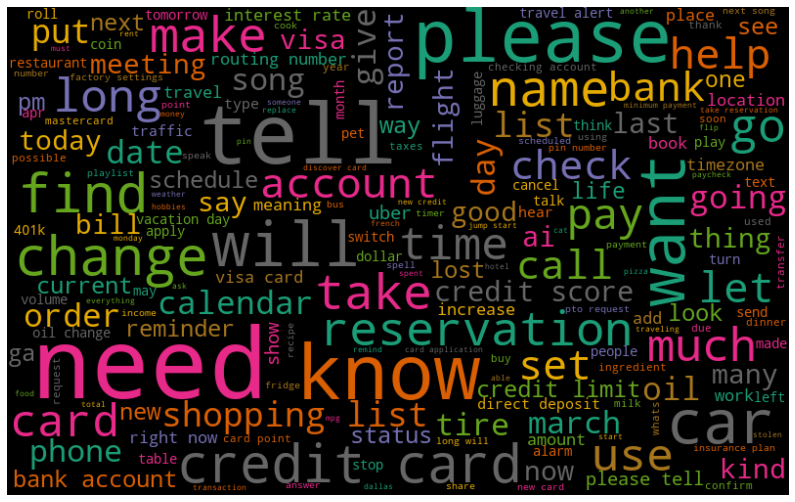

In [49]:
# WordCloud for the whole text of the dataframe
all_words = ' '.join([item for item in train_df['text']])
generate_wordcloud(all_words)

#### 3.1 WORDCLOUD PER SPECIFIC INTENT (2 random intents)

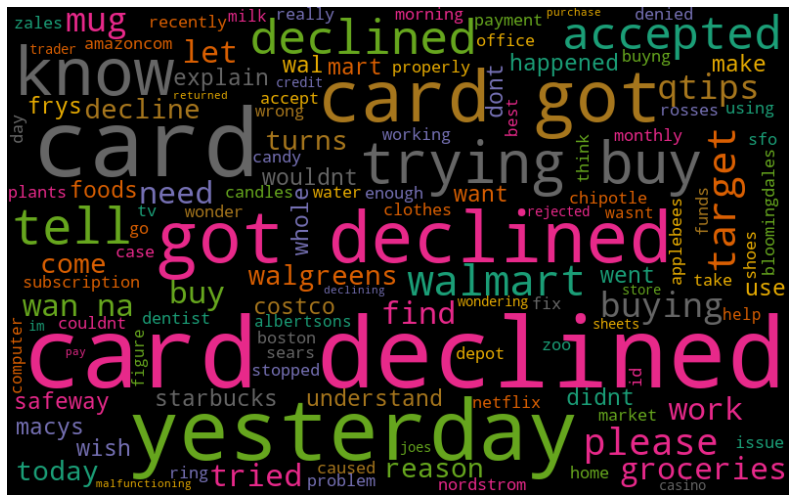

In [50]:
# WordCloud for a specific intent card_declined
all_words = ' '.join([item for item in grouped_train['cleaned_tokenized_text']['card_declined']])
generate_wordcloud(all_words)

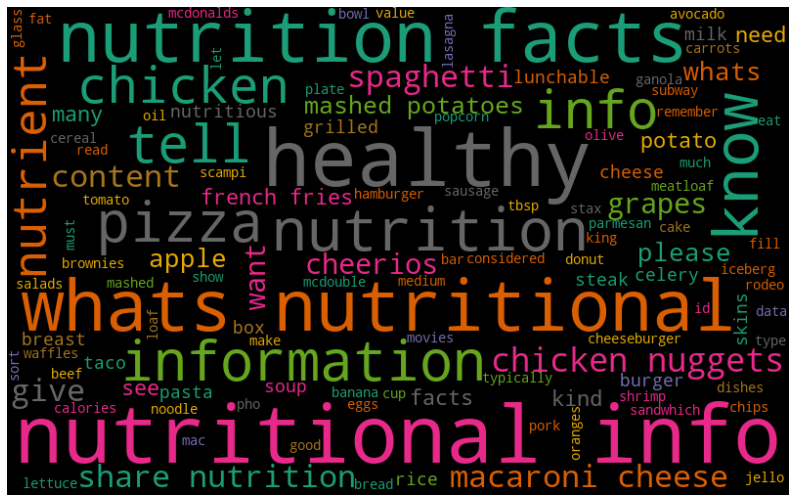

In [51]:
all_words = ' '.join([item for item in grouped_train['cleaned_tokenized_text']['nutrition_info']])
generate_wordcloud(all_words)

## CREATING CORPUS FOR 'money' RELATED TEXT

In [52]:
money_list = ['dollars', '$', 'cents', 'euros', 'usd', 'peso', 'pesos','dollar','rupees','rupee']
cnt = 0
money_corpus = []
for i in train_df['cleaned_text']:
    if any(word in i for word in money_list):
        money_corpus.append(i)
    else:
        pass

In [53]:
len(money_corpus)

143

In [54]:
money_corpus_df = pd.DataFrame()
money_corpus_df['text'] = money_corpus
#money_corpus_df.to_csv('money_corpus.csv', index=False)

#### SAVING TRAIN, VAL and TEST DATAFRAMES TO CSV FILES

In [55]:
#train_df.to_csv('train_data.csv', index=False)
#val_df.to_csv('val_data.csv', index=False)
#test_df.to_csv('test_data.csv', index=False)

### FILTERING THE DATAFRAME ON THREE RANDOM INTENTS

#### FILTERING ON TRAIN SET

In [55]:
# Specifying the seed so that we will always have the same rows
np.random.seed(0)

# Randomly selecting 3 unique rows of the target column (target -> numerical encoded of intents column) from the dataframe
three_intents_traindf = train_df[train_df['Target'].isin(train_df['Target'].sample(n=3))]

print('Three Intents train df_Target col value counts: ')
print(three_intents_traindf.Target.value_counts())
print()
print('Three Intents train df_intents col value counts: ')
print(three_intents_traindf.intent.value_counts())
print()
print('Three Intents train df_Target col unique values: ')
print(three_intents_traindf.Target.unique())
print()
print('Three Intents train df shape: ')
print(three_intents_traindf.shape)

Three Intents train df_Target col value counts: 
42    100
56    100
5     100
Name: Target, dtype: int64

Three Intents train df_intents col value counts: 
flight_status       100
ingredients_list    100
are_you_a_bot       100
Name: intent, dtype: int64

Three Intents train df_Target col unique values: 
[42 56  5]

Three Intents train df shape: 
(300, 6)


#### FILTERING ON VALIDATION SET

In [56]:
# selecting those 3 rows of the target column (target -> numerical encoded of intents column) from the dataframe based on train's target values
three_intents_valdf = val_df[val_df['Target'].isin(three_intents_traindf.Target.unique())]

print('Three Intents val df_Target col value counts: ')
print(three_intents_valdf.Target.value_counts())
print()
print('Three Intents val df_intents col value counts: ')
print(three_intents_valdf.intent.value_counts())
print()
print('Three Intents val df_Target col unique values: ')
print(three_intents_valdf.Target.unique())
print()
print('Three Intents val df shape: ')
print(three_intents_valdf.shape)

Three Intents val df_Target col value counts: 
42    20
56    20
5     20
Name: Target, dtype: int64

Three Intents val df_intents col value counts: 
flight_status       20
ingredients_list    20
are_you_a_bot       20
Name: intent, dtype: int64

Three Intents val df_Target col unique values: 
[42 56  5]

Three Intents val df shape: 
(60, 5)


#### FILTERING ON TEST SET

In [57]:
# selecting those 3 rows of the target column (target -> numerical encoded of intents column) from the dataframe based on train's target values
three_intents_testdf = test_df[test_df['Target'].isin(three_intents_traindf.Target.unique())]

print('Three Intents test df_Target col value counts: ')
print(three_intents_testdf.Target.value_counts())
print()
print('Three Intents test df_intents col value counts: ')
print(three_intents_testdf.intent.value_counts())
print()
print('Three Intents test df_Target col unique values: ')
print(three_intents_testdf.Target.unique())
print()
print('Three Intents test df shape: ')
print(three_intents_testdf.shape)

Three Intents test df_Target col value counts: 
42    30
56    30
5     30
Name: Target, dtype: int64

Three Intents test df_intents col value counts: 
flight_status       30
ingredients_list    30
are_you_a_bot       30
Name: intent, dtype: int64

Three Intents test df_Target col unique values: 
[42 56  5]

Three Intents test df shape: 
(90, 5)


### LINGUISTIC ANALYSIS FOR THESE THREE INTENTS
#### WORD FREQUENCIES

In [122]:
# Saving the 3 intents dataframes
# three_intents_traindf.to_csv('three_intents_train_data.csv', index=False)
# three_intents_valdf.to_csv('three_intents_val_data.csv', index=False)
# three_intents_testdf.to_csv('three_intents_test_data.csv', index=False)

In [61]:
# three_intents_traindf = pd.read_csv('three_intents_train_data.csv')
# three_intents_valdf   = pd.read_csv('three_intents_val_data.csv')
# three_intents_testdf  = pd.read_csv('three_intents_test_data.csv')

In [58]:
word_freq(three_intents_traindf.intent.unique()[0])

In [59]:
word_freq(three_intents_traindf.intent.unique()[1])

In [60]:
word_freq(three_intents_traindf.intent.unique()[2])

In [61]:
three_intents_traindf

text         intent  \
1600   what is the projected time frame for the fligh...  flight_status   
1601                   is there any news on flight dl123  flight_status   
1602                    what is the word on flight dl123  flight_status   
1603     when will we begin to board my scheduled flight  flight_status   
1604              whats the status of my frontier flight  flight_status   
...                                                  ...            ...   
13395           tell me if you are a human or a computer  are_you_a_bot   
13396   can you specify if you are a human or a computer  are_you_a_bot   
13397       let me know if you are a human or a computer  are_you_a_bot   
13398      is this a computer right now or a human being  are_you_a_bot   
13399                           is this human or a robot  are_you_a_bot   

                                          tokenized_text  \
1600   [what, is, the, projected, time, frame, for, t...   
1601           [is, there, any, news, on, flight, dl123]   
1602            [what, is, the, word, on, flight, dl123]   
1603   [when, will, we, begin, to, board, my, schedul...   
1604      [whats, the, status, of, my, frontier, flight]   
...                                                  ...   
13395  [tell, me, if, you, are, a, human, or, a, comp...   
13396  [can, you, specify, if, you, are, a, human, or...   
13397  [let, me, know, if, you, are, a, human, or, a,...   
13398  [is, this, a, computer, right, now, or, a, hum...   
13399                    [is, this, human, or, a, robot]   

                                            cleaned_text  \
1600   what is the projected time frame for the fligh...   
1601                   is there any news on flight dl123   
1602                    what is the word on flight dl123   
1603     when will we begin to board my scheduled flight   
1604              whats the status of my frontier flight   
...                                                  ...   
13395           tell me if you are a human or a computer   
13396   can you specify if you are a human or a computer   
13397       let me know if you are a human or a computer   
13398      is this a computer right now or a human being   
13399                           is this human or a robot   

                       cleaned_tokenized_text  Target  
1600   [projected, time, frame, flight, land]      42  
1601                    [news, flight, dl123]      42  
1602                    [word, flight, dl123]      42  
1603        [begin, board, scheduled, flight]      42  
1604        [whats, status, frontier, flight]      42  
...                                       ...     ...  
13395                 [tell, human, computer]       5  
13396              [specify, human, computer]       5  
13397            [let, know, human, computer]       5  
13398                [computer, right, human]       5  
13399                          [human, robot]       5  

[300 rows x 6 columns]

#### NGRAMS

In [62]:
# Top Bigrams for specific intent
bigrams = ngrams_top([grouped_train['text'][three_intents_traindf.intent.unique()[0]]],(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#FFA07A'],opacity=0.8,width=900,height=500, title=f'Bigrams Bar Chart_For Intent:-{three_intents_traindf.intent.unique()[0]}')

In [63]:
bigrams = ngrams_top([grouped_train['text'][three_intents_traindf.intent.unique()[1]]],(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#f58518'],opacity=0.8,width=900,height=500, title=f'Bigrams Bar Chart_For Intent:-{three_intents_traindf.intent.unique()[1]}')

In [64]:
bigrams = ngrams_top([grouped_train['text'][three_intents_traindf.intent.unique()[2]]],(2,2)).sort_values(by='count')
px.bar(data_frame=bigrams,y='text',x='count',orientation='h',color_discrete_sequence=['#DE3163'],opacity=0.8,width=900,height=500, title=f'Bigrams Bar Chart_For Intent:-{three_intents_traindf.intent.unique()[2]}')

#### WORDCLOUD

Intent:- flight_status


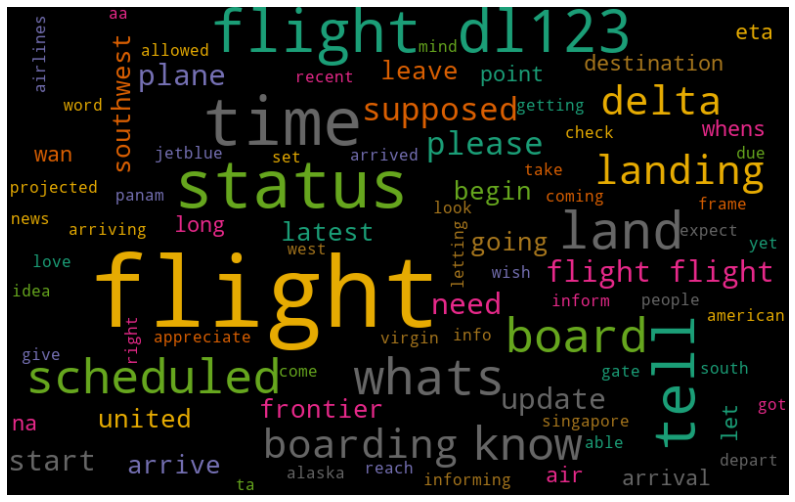

In [65]:
all_words = ' '.join([item for item in grouped_train['cleaned_tokenized_text'][three_intents_traindf.intent.unique()[0]]])
print('Intent:-',three_intents_traindf.intent.unique()[0])
generate_wordcloud(all_words)

Intent:- ingredients_list


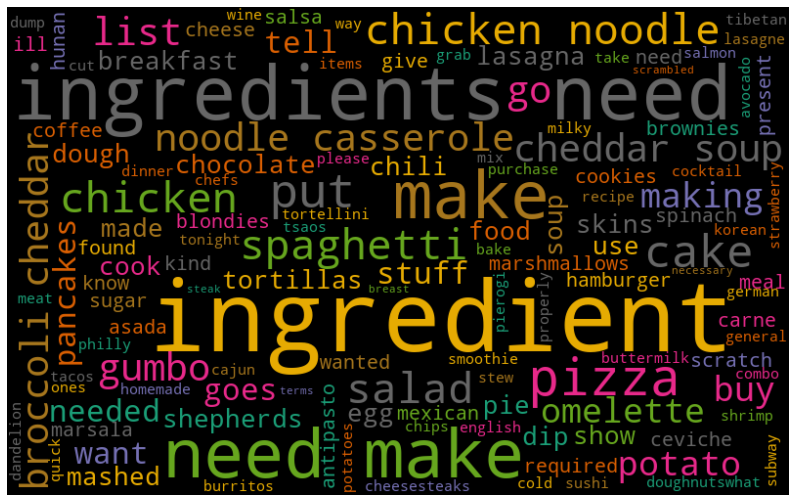

In [66]:
all_words = ' '.join([item for item in grouped_train['cleaned_tokenized_text'][three_intents_traindf.intent.unique()[1]]])
print('Intent:-',three_intents_traindf.intent.unique()[1])
generate_wordcloud(all_words)

Intent:- are_you_a_bot


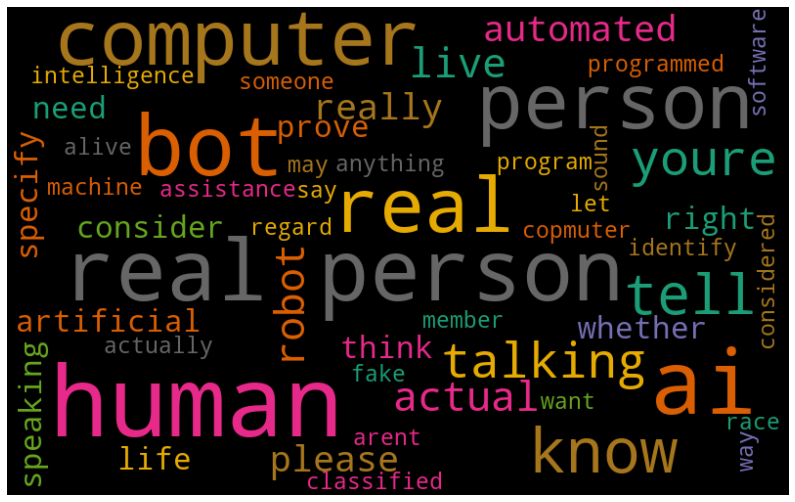

In [67]:
all_words = ' '.join([item for item in grouped_train['cleaned_tokenized_text'][three_intents_traindf.intent.unique()[2]]])
print('Intent:-',three_intents_traindf.intent.unique()[2])
generate_wordcloud(all_words)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. MODELLING WITH DIFFERENT WORD EMBEDDINGS</h2>

</div>

## STATIC WORD EMBEDDINGS

### 1. Word2vec (SKIPGRAM)

In [68]:
# Create Skip Gram model
model_sg = gensim.models.Word2Vec(train_df['cleaned_tokenized_text'], min_count = 1, vector_size = 100, window = 5, sg = 1, workers = 4)

In [69]:
# Saving skipgram model
# model_sg.save('word2vec_skipgram_150intents.model')

# Loading skipgram model
#loaded_sg_150_model = Word2Vec.load("word2vec_skipgram_150intents.model")

In [70]:
model_sg.wv.most_similar('time')

[('paid', 0.9738958477973938),
 ('year', 0.9643425345420837),
 ('day', 0.9633602499961853),
 ('miles', 0.9624411463737488),
 ('holiday', 0.9537367820739746),
 ('week', 0.952694833278656),
 ('gallon', 0.9512583613395691),
 ('far', 0.9502949714660645),
 ('taken', 0.9500401616096497),
 ('per', 0.9498676657676697)]

#### We have to combine the vectors (vectors -> vector representations of each word) together and get a new one that represents the document as a whole. Here, we are computing a weighted average where each weight gives the importance of the word with respect to the corpus. Such a weight could be the tf-idf score.

In [71]:
# Building a tf-idf matrix
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in train_df['cleaned_tokenized_text']])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 920


In [72]:
# Function to create an averaged document vector when given a list of tokens of the same document
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_sg.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [73]:
# Building the sentence embeddings for train, val and test sets respectively
train_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x, train_df['cleaned_tokenized_text']))])
train_vecs_w2v = scale(train_vecs_w2v)

val_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x, val_df['cleaned_tokenized_text']))])
val_vecs_w2v = scale(val_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x, test_df['cleaned_tokenized_text']))])
test_vecs_w2v = scale(test_vecs_w2v)

15000it [00:00, 60466.51it/s]
3000it [00:00, 61192.60it/s]
4500it [00:00, 59214.45it/s]


#### Word2Vec SKIPGRAM on THREE INTENTS DATAFRAMES 

In [108]:
model_sg_3intents = gensim.models.Word2Vec(three_intents_traindf['cleaned_tokenized_text'], min_count = 1, vector_size = 100, window = 5, sg = 1, workers = 4)

In [109]:
# Saving 3 intents skipgram word embeddings model
# model_sg_3intents.save('word2vec_skipgram_3intents.model')

In [103]:
# Building a tf-idf matrix
print('building tf-idf matrix ...')
vectorizer_3i = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
vectorizer_3i.fit_transform([x for x in three_intents_traindf['cleaned_tokenized_text']])
tfidf_3i = dict(zip(vectorizer_3i.get_feature_names(), vectorizer_3i.idf_))
print('vocab size :', len(tfidf_3i))

building tf-idf matrix ...
vocab size : 20


In [105]:
tfidf_3i['time']

3.488234439880675

In [107]:
model_sg_3intents.wv['flight']

array([-0.0006916 ,  0.00111792,  0.00583244,  0.00858837, -0.0087697 ,
       -0.00957068,  0.00726438,  0.01073483, -0.00598534, -0.00489765,
        0.00750916, -0.00238109, -0.00418039,  0.00652252, -0.00433097,
       -0.00227968,  0.00339876,  0.00021578, -0.0089071 , -0.01138474,
        0.00782548,  0.00565137,  0.00742551,  0.00037985,  0.00641436,
       -0.00286567, -0.00125422,  0.00625659, -0.00815629, -0.00441768,
       -0.00664792, -0.00078709,  0.01078302, -0.00785298, -0.00224074,
       -0.00039585,  0.00843571, -0.00625635, -0.00076379, -0.00589708,
       -0.00951724,  0.00406767, -0.00986445, -0.00431831,  0.00058303,
       -0.00102476, -0.00848426,  0.00927289,  0.00524889,  0.00982242,
       -0.0076313 ,  0.00339141, -0.00440985,  0.00058993,  0.00871712,
       -0.0034041 ,  0.00497223, -0.00639199, -0.00412756,  0.01072791,
       -0.00175855,  0.00028549, -0.00407676, -0.00799478, -0.0026678 ,
        0.00400023, -0.0010949 ,  0.00650429, -0.00358462,  0.00

In [76]:
# For 3 intents
# Function to create an averaged document vector when given a list of tokens of the same document
def buildWordVector_3i(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_sg_3intents.wv[word].reshape((1, size)) * tfidf_3i[word]
            count += 1.
        except KeyError: # handling the case where the token is not in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [77]:
# Building the sentence embeddings for train, val and test sets respectively
train_vecs_w2v_3i = np.concatenate([buildWordVector_3i(z, 100) for z in tqdm(map(lambda x: x, three_intents_traindf['cleaned_tokenized_text']))])
train_vecs_w2v_3i = scale(train_vecs_w2v_3i)

val_vecs_w2v_3i = np.concatenate([buildWordVector_3i(z, 100) for z in tqdm(map(lambda x: x, three_intents_valdf['cleaned_tokenized_text']))])
val_vecs_w2v_3i = scale(val_vecs_w2v_3i)

test_vecs_w2v_3i = np.concatenate([buildWordVector_3i(z, 100) for z in tqdm(map(lambda x: x, three_intents_testdf['cleaned_tokenized_text']))])
test_vecs_w2v_3i = scale(test_vecs_w2v_3i)

300it [00:00, 75000.97it/s]
60it [00:00, 54875.32it/s]
90it [00:00, 82366.87it/s]


### 2. Count Vectorizer

In [78]:
# initializing countvectorizer model
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
vec = vectorizer.fit_transform(train_df['cleaned_text'])
print(vec.shape)
train_vec_cv = vec.toarray()
np.unique(train_vec_cv)

(15000, 26120)


array([0, 1, 2], dtype=int64)

In [79]:
# Count Vectorize validation set
val_vec_cv = vectorizer.transform(val_df['cleaned_text']).toarray()
val_vec_cv.shape

(3000, 26120)

In [80]:
# Count Vectorize test set
test_vec_cv = vectorizer.transform(test_df['cleaned_text']).toarray()
test_vec_cv.shape

(4500, 26120)

#### Count Vectorizer on THREE INTENTS DATAFRAMES

In [81]:
vectorizer_3i = CountVectorizer(analyzer='word', ngram_range=(2, 2))
three_intents_train_vec_cv = vectorizer_3i.fit_transform(three_intents_traindf['cleaned_text']).toarray()
three_intents_train_vec_cv.shape

(300, 713)

In [82]:
three_intents_val_vec_cv = vectorizer_3i.transform(three_intents_valdf['cleaned_text']).toarray()
three_intents_val_vec_cv.shape

(60, 713)

In [83]:
three_intents_test_vec_cv = vectorizer_3i.transform(three_intents_testdf['cleaned_text']).toarray()
three_intents_test_vec_cv.shape

(90, 713)

## CONTEXTUAL WORD EMBEDDINGS

### 1. SENTENCE BERT

In [84]:
# For Train set
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

train_sentences_list = []
for sent in train_df['cleaned_text']:
    train_sentences_list.append(sent)

#Sentences are encoded by calling model.encode()
train_embeddings = model.encode(train_sentences_list)

train_sent_embeddings = []
#Generate the embeddings
for sentence, embedding in zip(train_sentences_list, train_embeddings):
    train_sent_embeddings.append(embedding)

In [97]:
# For Val set
val_sentences_list = []
for sent in val_df['cleaned_text']:
    val_sentences_list.append(sent)

#Sentences are encoded by calling model.encode()
val_embeddings = model.encode(val_sentences_list)

val_sent_embeddings = []
#Generate the embeddings
for sentence, embedding in zip(val_sentences_list, val_embeddings):
    val_sent_embeddings.append(embedding)

In [75]:
# For Test set
test_sentences_list = []
for sent in test_df['cleaned_text']:
    test_sentences_list.append(sent)

#Sentences are encoded by calling model.encode()
test_embeddings = model.encode(test_sentences_list)

test_sent_embeddings = []
#Generate the embeddings
for sentence, embedding in zip(test_sentences_list, test_embeddings):
    test_sent_embeddings.append(embedding)

#### SENTENCE BERT ON THREE INTENTS DATAFRAMES

In [76]:
# three_intents train set
train_sentences_list_3i = []
for sent in three_intents_traindf['cleaned_text']:
    train_sentences_list_3i.append(sent)

#Sentences are encoded by calling model.encode()
train_embeddings_3i = model.encode(train_sentences_list_3i)

train_sent_embeddings_3i = []
#Generate the embeddings
for sentence, embedding in zip(train_sentences_list_3i, train_embeddings_3i):
    train_sent_embeddings_3i.append(embedding)

In [77]:
# three intents Val set
val_sentences_list_3i = []
for sent in three_intents_valdf['cleaned_text']:
    val_sentences_list_3i.append(sent)

#Sentences are encoded by calling model.encode()
val_embeddings_3i = model.encode(val_sentences_list_3i)

val_sent_embeddings_3i = []
#Generate the embeddings
for sentence, embedding in zip(val_sentences_list_3i, val_embeddings_3i):
    val_sent_embeddings_3i.append(embedding)

In [78]:
# three intents Test set
test_sentences_list_3i = []
for sent in three_intents_testdf['cleaned_text']:
    test_sentences_list_3i.append(sent)

#Sentences are encoded by calling model.encode()
test_embeddings_3i = model.encode(test_sentences_list_3i)

test_sent_embeddings_3i = []
#Generate the embeddings
for sentence, embedding in zip(test_sentences_list_3i, test_embeddings_3i):
    test_sent_embeddings_3i.append(embedding)

# MODEL BUILDING

## 1. RANDOM FOREST

### RANDOM FOREST with Word2Vec (SKIPGRAM)

In [79]:
# Training the model for 150 intents
rf = RandomForestClassifier()
rf.fit(train_vecs_w2v, train_df['Target'])

# ROC AUC Score on validation set of rf model for 150 intents
roc_auc_score(val_df['Target'], rf.predict_proba(val_vecs_w2v), multi_class='ovr')

0.9649437360178972

In [80]:
# Training the model for 3 intents
rf_3i = RandomForestClassifier()
rf_3i.fit(train_vecs_w2v_3i, three_intents_traindf['Target'])

# ROC AUC Score on validation set of rf model for 3 intents
roc_auc_score(three_intents_valdf['Target'], rf_3i.predict_proba(val_vecs_w2v_3i), multi_class='ovr')

1.0

In [81]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest, train_set):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={train_set.Target.unique()[0]: train_set.intent.unique()[0], 
                                        train_set.Target.unique()[1]: train_set.intent.unique()[1], 
                                        train_set.Target.unique()[2]: train_set.intent.unique()[2]})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

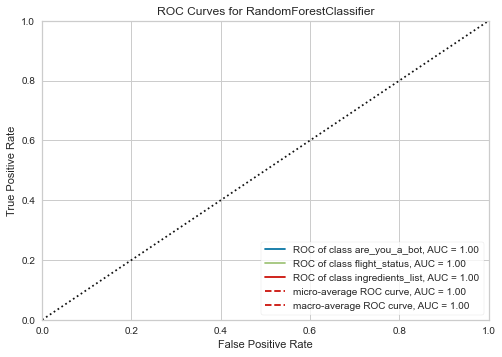

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=RandomForestClassifier())

In [82]:
plot_ROC_curve(rf_3i, train_vecs_w2v_3i, three_intents_traindf['Target'], val_vecs_w2v_3i, three_intents_valdf['Target'], three_intents_traindf)

In [83]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], rf_3i.predict(val_vecs_w2v_3i)))

Classification Report : 
               precision    recall  f1-score   support

           5       1.00      1.00      1.00        20
          42       1.00      1.00      1.00        20
          56       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [84]:
# Saving rf skipgram 150 intents
joblib.dump(rf, "random_forest_sg_150.pkl")

# load
loaded_rf_sg_150 = joblib.load("random_forest_sg_150.pkl")

In [85]:
# Saving rf skipgram 3 intents
joblib.dump(rf_3i, "random_forest_sg_3i.pkl")

# load
loaded_rf_sg_3i = joblib.load("random_forest_sg_3i.pkl")

In [86]:
# F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_rf_sg_150.predict(val_vecs_w2v), average='macro')

0.6624142042982822

In [88]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_rf_sg_3i.predict(val_vecs_w2v_3i), average='macro')

1.0

### RANDOM FOREST with Count Vectorizer

In [89]:
# Training the model for 150 intents
rf_cv = RandomForestClassifier()
rf_cv.fit(train_vec_cv, train_df['Target'])

RandomForestClassifier()

In [90]:
# ROC AUC Score on validation set of rf model for 150 intents
roc_auc_score(val_df['Target'], rf_cv.predict_proba(val_vec_cv), multi_class='ovr')

0.9686373042505594

In [91]:
# Training the model for 3 intents
rf_3i_cv = RandomForestClassifier().fit(three_intents_train_vec_cv, three_intents_traindf['Target'])
roc_auc_score(three_intents_valdf['Target'], rf_3i_cv.predict_proba(three_intents_val_vec_cv), multi_class='ovr')

0.9997916666666665

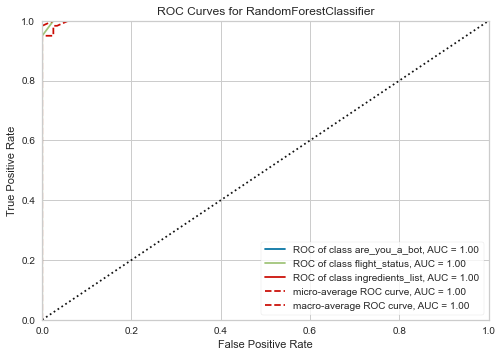

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=RandomForestClassifier())

In [92]:
plot_ROC_curve(rf_3i_cv, three_intents_train_vec_cv, three_intents_traindf['Target'], three_intents_val_vec_cv, three_intents_valdf['Target'], three_intents_traindf)

In [93]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], rf_3i_cv.predict(three_intents_val_vec_cv)))

Classification Report : 
               precision    recall  f1-score   support

           5       0.87      1.00      0.93        20
          42       1.00      0.90      0.95        20
          56       1.00      0.95      0.97        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



In [94]:
# Saving rf count vectorizer 150 intents
joblib.dump(rf_cv, "random_forest_cv_150.pkl")

# load
loaded_rf_cv_150 = joblib.load("random_forest_cv_150.pkl")

In [95]:
# Saving rf count vectorizer 3 intents
joblib.dump(rf_3i_cv, "random_forest_cv_3i.pkl")

# load
loaded_rf_3i_cv = joblib.load("random_forest_cv_3i.pkl")

In [96]:
# F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_rf_cv_150.predict(val_vec_cv), average='macro')

0.7460097951152623

In [97]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_rf_3i_cv.predict(three_intents_val_vec_cv), average='macro')

0.9506533178503803

### RANDOM FOREST with SENTENCE BERT

In [98]:
# Training the model for 150 intents
rf_sbert = RandomForestClassifier()
rf_sbert.fit(train_sent_embeddings, train_df['Target'])

# ROC AUC Score on validation set of rf model
roc_auc_score(val_df['Target'], rf_sbert.predict_proba(val_sent_embeddings), multi_class='ovr')

0.9941868568232664

In [99]:
# Training the model for 3 intents
rf_3i_sbert = RandomForestClassifier().fit(train_sent_embeddings_3i, three_intents_traindf['Target'])
roc_auc_score(three_intents_valdf['Target'], rf_3i_sbert.predict_proba(val_sent_embeddings_3i), multi_class='ovr')

1.0

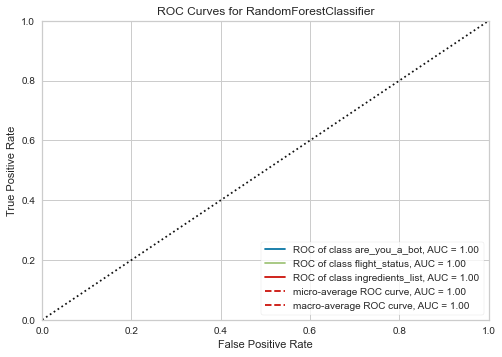

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=RandomForestClassifier())

In [100]:
plot_ROC_curve(rf_3i_sbert, train_sent_embeddings_3i, three_intents_traindf['Target'], val_sent_embeddings_3i, three_intents_valdf['Target'], three_intents_traindf)

In [101]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], rf_3i_sbert.predict(val_sent_embeddings_3i)))

Classification Report : 
               precision    recall  f1-score   support

           5       1.00      1.00      1.00        20
          42       1.00      1.00      1.00        20
          56       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [102]:
# Saving rf sentence bert 150 intents
joblib.dump(rf_sbert, "random_forest_sbert_150.pkl")

# load
loaded_rf_sbert_150 = joblib.load("random_forest_sbert_150.pkl")

In [103]:
# Saving rf sentence bert 3 intents
joblib.dump(rf_3i_sbert, "random_forest_sbert_3i.pkl")

# load
loaded_rf_3i_sbert = joblib.load("random_forest_sbert_3i.pkl")

In [104]:
# F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_rf_sbert_150.predict(val_sent_embeddings), average='macro')

0.8880647930717221

In [105]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_rf_3i_sbert.predict(val_sent_embeddings_3i), average='macro')

1.0

## 2. LOGISTIC REGRESSION

### LOGISTIC REGRESSION with Word2Vec (SKIPGRAM)

In [106]:
# Training the model for 150 intents
lr_sg = LogisticRegression(random_state=0, n_jobs=-1)
lr_sg.fit(train_vecs_w2v, train_df['Target'])

# ROC AUC Score on validation set of lr model for 150 intents
roc_auc_score(val_df['Target'], lr_sg.predict_proba(val_vecs_w2v), multi_class='ovr')

0.9854964205816554

In [107]:
# Training the model for 3 intents
lr_sg_3i = LogisticRegression(random_state=0, n_jobs=-1)
lr_sg_3i.fit(train_vecs_w2v_3i, three_intents_traindf['Target'])

# ROC AUC Score on validation set of lr model for 3 intents
roc_auc_score(three_intents_valdf['Target'], lr_sg_3i.predict_proba(val_vecs_w2v_3i), multi_class='ovr')

1.0

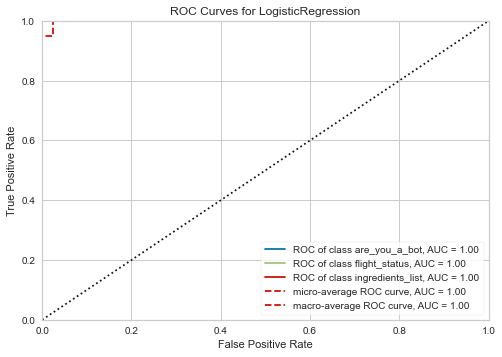

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=LogisticRegression(n_jobs=-1, random_state=0))

In [108]:
plot_ROC_curve(lr_sg_3i, train_vecs_w2v_3i, three_intents_traindf['Target'], val_vecs_w2v_3i, three_intents_valdf['Target'], three_intents_traindf)

In [109]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], lr_sg_3i.predict(val_vecs_w2v_3i)))

Classification Report : 
               precision    recall  f1-score   support

           5       1.00      0.85      0.92        20
          42       1.00      1.00      1.00        20
          56       0.87      1.00      0.93        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



In [110]:
# Saving rf skipgram 150 intents
joblib.dump(lr_sg, "logistic_regression_sg_150.pkl")

# load
loaded_lr_sg_150 = joblib.load("logistic_regression_sg_150.pkl")

In [111]:
# Saving rf skipgram 3 intents
joblib.dump(lr_sg_3i, "logistic_regression_sg_3i.pkl")

# load
loaded_lr_sg_3i = joblib.load("logistic_regression_sg_3i.pkl")

In [112]:
## F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_lr_sg_150.predict(val_vecs_w2v), average='macro')

0.7364748076723715

In [113]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_lr_sg_3i.predict(val_vecs_w2v_3i), average='macro')

0.9497171590194845

### LOGISTIC REGRESSION with Count Vectorizer

In [114]:
# Training the lr model for 150 intents
lr_cv = LogisticRegression(random_state=0, n_jobs=-1)
lr_cv.fit(train_vec_cv, train_df['Target'])

LogisticRegression(n_jobs=-1, random_state=0)

In [115]:
# ROC AUC Score on validation set of lr model for 150 intents
roc_auc_score(val_df['Target'], lr_cv.predict_proba(val_vec_cv), multi_class='ovr')

0.9903702460850112

In [116]:
# Training the model for 3 intents
lr_3i_cv = LogisticRegression(random_state=0, n_jobs=-1).fit(three_intents_train_vec_cv, three_intents_traindf['Target'])
roc_auc_score(three_intents_valdf['Target'], lr_3i_cv.predict_proba(three_intents_val_vec_cv), multi_class='ovr')

1.0

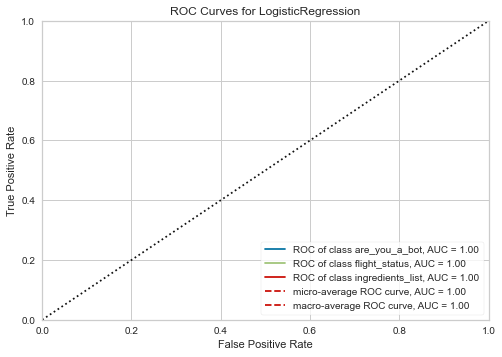

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=LogisticRegression(n_jobs=-1, random_state=0))

In [117]:
plot_ROC_curve(lr_3i_cv, three_intents_train_vec_cv, three_intents_traindf['Target'], three_intents_val_vec_cv, three_intents_valdf['Target'], three_intents_traindf)

In [118]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], lr_3i_cv.predict(three_intents_val_vec_cv)))

Classification Report : 
               precision    recall  f1-score   support

           5       1.00      1.00      1.00        20
          42       1.00      1.00      1.00        20
          56       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [119]:
# Saving lr count vectorizer 150 intents
joblib.dump(lr_cv, "logistic_regression_cv_150.pkl")

# load
loaded_lr_cv_150 = joblib.load("logistic_regression_cv_150.pkl")

In [120]:
# Saving lr count vectorizer 3 intents
joblib.dump(lr_3i_cv, "logistic_regression_cv_3i.pkl")

# load
loaded_lr_cv_3i = joblib.load("logistic_regression_cv_3i.pkl")

In [121]:
# F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_lr_cv_150.predict(val_vec_cv), average='macro')

0.7807001775333827

In [122]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_lr_cv_3i.predict(three_intents_val_vec_cv), average='macro')

1.0

### LOGISTIC REGRESSION with SENTENCE BERT

In [123]:
# Training the model for 150 intents
lr_sbert = LogisticRegression(random_state=0, n_jobs=-1)
lr_sbert.fit(train_sent_embeddings, train_df['Target'])

# ROC AUC Score on validation set of rf model
roc_auc_score(val_df['Target'], lr_sbert.predict_proba(val_sent_embeddings), multi_class='ovr')

0.9989079418344519

In [124]:
# Training the model for 3 intents
lr_3i_sbert = LogisticRegression(random_state=0, n_jobs=-1).fit(train_sent_embeddings_3i, three_intents_traindf['Target'])
roc_auc_score(three_intents_valdf['Target'], lr_3i_sbert.predict_proba(val_sent_embeddings_3i), multi_class='ovr')

1.0

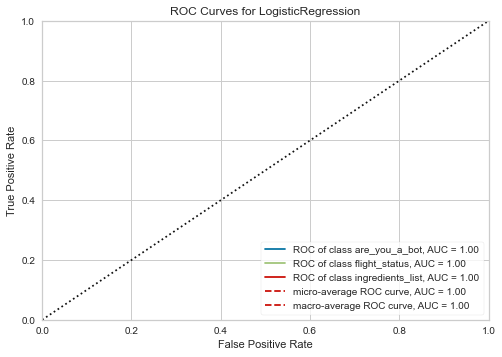

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={5: 'are_you_a_bot', 42: 'flight_status',
                56: 'ingredients_list'},
       estimator=LogisticRegression(n_jobs=-1, random_state=0))

In [125]:
plot_ROC_curve(lr_3i_sbert, train_sent_embeddings_3i, three_intents_traindf['Target'], val_sent_embeddings_3i, three_intents_valdf['Target'], three_intents_traindf)

In [126]:
print("Classification Report : \n",classification_report(three_intents_valdf['Target'], lr_3i_sbert.predict(val_sent_embeddings_3i)))

Classification Report : 
               precision    recall  f1-score   support

           5       1.00      1.00      1.00        20
          42       1.00      1.00      1.00        20
          56       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [127]:
# Saving lr setence bert 150 intents
joblib.dump(lr_sbert, "logistic_regression_sbert_150.pkl")

# load
loaded_lr_sbert_150 = joblib.load("logistic_regression_sbert_150.pkl")

In [128]:
# Saving lr sentence bert 3 intents
joblib.dump(lr_3i_sbert, "logistic_regression_sbert_3i.pkl")

# load
loaded_lr_sbert_3i = joblib.load("logistic_regression_sbert_3i.pkl")

In [129]:
# F1 score on val set 150 intents
f1_score(val_df['Target'], loaded_lr_sbert_150.predict(val_sent_embeddings), average='macro')

0.9472071861576891

In [130]:
# F1 score on val set 3 intents
f1_score(three_intents_valdf['Target'], loaded_lr_sbert_3i.predict(val_sent_embeddings_3i), average='macro')

1.0

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Sequence Labelling - BIO TAGGING</h2>

</div>

## Reference
https://huggingface.co/transformers/v4.2.2/custom_datasets.html <br>
https://huggingface.co/transformers/v4.2.2/custom_datasets.html#ft-native

In [48]:
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')
from transformers import BertConfig, AutoTokenizer, TFAutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification, DistilBertTokenizerFast, DistilBertForTokenClassification
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [49]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [26]:
df = pd.read_csv('money_corpus.csv')

In [27]:
df.reset_index(inplace=True)

In [28]:
df.rename(columns={'index':'sentence #'},inplace=True)

In [29]:
df['sentence #'] = df['sentence #'].apply(lambda x : 'sentence:'+str(x))

In [31]:
df['text'] = df['text'].apply(lambda x : x.split())

In [33]:
# df = df.explode('text')

In [37]:
# df.to_csv('exploded_text.csv',index=False)

## Loading the tagged data

In [6]:
tagged = pd.read_csv('exploded_text.csv')

In [7]:
tagged

sentence #      text    tag
0       sentence:0       how      O
1       sentence:0     would      O
2       sentence:0       you      O
3       sentence:0       say      O
4       sentence:0       can      O
...            ...       ...    ...
1327  sentence:140     limit      O
1328  sentence:140        to      O
1329  sentence:140       one  B-mon
1330  sentence:140  thousand  I-mon
1331  sentence:140   dollars  I-mon

[1332 rows x 3 columns]

In [8]:
tagged['sentence'] = tagged[['sentence #','text','tag']].groupby(['sentence #'])['text'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
tagged['word_labels'] = tagged[['sentence #','text','tag']].groupby(['sentence #'])['tag'].transform(lambda x: ','.join(x))

In [9]:
tagged

sentence #      text    tag  \
0       sentence:0       how      O   
1       sentence:0     would      O   
2       sentence:0       you      O   
3       sentence:0       say      O   
4       sentence:0       can      O   
...            ...       ...    ...   
1327  sentence:140     limit      O   
1328  sentence:140        to      O   
1329  sentence:140       one  B-mon   
1330  sentence:140  thousand  I-mon   
1331  sentence:140   dollars  I-mon   

                                               sentence  \
0     how would you say can i borrow five dollars in...   
1     how would you say can i borrow five dollars in...   
2     how would you say can i borrow five dollars in...   
3     how would you say can i borrow five dollars in...   
4     how would you say can i borrow five dollars in...   
...                                                 ...   
1327  please see if you can increase my credit limit...   
1328  please see if you can increase my credit limit...   
1329  please see if you can increase my credit limit...   
1330  please see if you can increase my credit limit...   
1331  please see if you can increase my credit limit...   

                                word_labels  
0             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
1             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
2             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
3             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
4             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
...                                     ...  
1327  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1328  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1329  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1330  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1331  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  

[1332 rows x 5 columns]

In [10]:
tagged_final = tagged[['sentence', 'word_labels']]

In [11]:
tagged_final

sentence  \
0     how would you say can i borrow five dollars in...   
1     how would you say can i borrow five dollars in...   
2     how would you say can i borrow five dollars in...   
3     how would you say can i borrow five dollars in...   
4     how would you say can i borrow five dollars in...   
...                                                 ...   
1327  please see if you can increase my credit limit...   
1328  please see if you can increase my credit limit...   
1329  please see if you can increase my credit limit...   
1330  please see if you can increase my credit limit...   
1331  please see if you can increase my credit limit...   

                                word_labels  
0             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
1             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
2             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
3             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
4             O,O,O,O,O,O,O,B-mon,I-mon,O,O  
...                                     ...  
1327  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1328  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1329  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1330  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
1331  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  

[1332 rows x 2 columns]

In [12]:
tagged_final = tagged_final.drop_duplicates().reset_index(drop=True)

In [13]:
tagged_final

sentence  \
0    how would you say can i borrow five dollars in...   
1    send 100 dollars between bank of the west and ...   
2    send 50 dollars between bank of america and ch...   
3    send 2000 dollars between chase and rabobank a...   
4    send 1200 dollars between usaa and navy federa...   
..                                                 ...   
136     can i increase my credit limit to 1100 dollars   
137  can you increase my credit limit to one thousa...   
138  can my credit limit be increased to one thousa...   
139  tell me if my credit limit can be increased to...   
140  please see if you can increase my credit limit...   

                               word_labels  
0            O,O,O,O,O,O,O,B-mon,I-mon,O,O  
1        O,B-mon,I-mon,O,O,O,O,O,O,O,O,O,O  
2              O,B-mon,I-mon,O,O,O,O,O,O,O  
3                  O,B-mon,I-mon,O,O,O,O,O  
4                O,B-mon,I-mon,O,O,O,O,O,O  
..                                     ...  
136              O,O,O,O,O,O,O,B-mon,I-mon  
137        O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
138        O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
139  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  
140  O,O,O,O,O,O,O,O,O,O,B-mon,I-mon,I-mon  

[141 rows x 2 columns]

In [14]:
tagged.tag.unique()

array(['O', 'B-mon', 'I-mon'], dtype=object)

In [15]:
label_to_id = {v:k for k,v in enumerate(tagged.tag.unique())}
id_to_label = {k:v for k,v in enumerate(tagged.tag.unique())}

In [16]:
label_to_id

{'O': 0, 'B-mon': 1, 'I-mon': 2}

In [17]:
id_to_label

{0: 'O', 1: 'B-mon', 2: 'I-mon'}

In [18]:
MAX_LEN = 64
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-04
MAX_GRAD_NORM = 10

In [19]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [61]:
train_size = 0.91
train_dataset = tagged_final.sample(frac=train_size, random_state=0)
test_dataset = tagged_final.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(tagged_final.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (141, 2)
TRAIN Dataset: (128, 2)
TEST Dataset: (13, 2)


In [63]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip()
        word_labels = self.data.word_labels[index].split(',')
        non_zero_ids = []

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        
        labels = [label_to_id[label] for label in word_labels]
        
        for id, label in enumerate(labels):
            if int(label) > 0:
                non_zero_ids.append(id)
       
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        for id in non_zero_ids:
            encoded_labels[id] = labels[id]

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

    def __len__(self):
        return self.len

In [64]:
training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

In [65]:
train_dataset['sentence'][2]

'transfer sixty dollars to dad from my biggest accnt'

In [66]:
train_dataset['word_labels'][2]

'O,B-mon,I-mon,O,O,O,O,O,O'

In [67]:
training_set[2]

{'input_ids': tensor([  101,  4651,  8442,  6363,  2000,  3611,  2013,  2026,  5221, 16222,
          3372,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'offset_mapping': tensor([[ 0,  0],
         [ 0,  8],
         [ 9, 14],
         [15, 22],
         [23, 25],
         [26, 29],
         [30, 34],
         [35, 37],
         [38, 45],
         [46, 49],
         [49, 51],
        

In [68]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Simple BERT

In [34]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_to_id))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [35]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [36]:
def train(epoch):
    loss, accuracy = 0, 0
    no_train_samples, no_steps =0 , 0
    pred_train, label_train = [], []
    
    model.train()
    
    for i, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype= torch.long)
        mask = batch['attention_mask'].to(device, dtype= torch.long)
        labels = batch['labels'].to(device, dtype= torch.long)
        res = model(input_ids = ids, attention_mask= mask, labels = labels)
        loss += res[0]
        no_steps+=1
        no_train_samples+=labels.size(0)
        
        if i % 5 ==0:
            loss_step = loss/no_steps
            print(f"Training loss per 5 training steps: {loss_step}")
            
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = res[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        
        label_train.extend(labels)
        pred_train.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        res['loss'].backward()
        optimizer.step()

    epoch_loss = loss / no_steps
    tr_accuracy = accuracy / no_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [37]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 5 training steps: 1.2308019399642944
Training loss per 5 training steps: 0.6021385192871094
Training loss per 5 training steps: 0.40730807185173035
Training loss per 5 training steps: 0.3008166551589966
Training loss per 5 training steps: 0.2377745509147644
Training loss epoch: 0.2447919100522995
Training accuracy epoch: 0.8922222222222222
Training epoch: 2
Training loss per 5 training steps: 0.005527029279619455
Training loss per 5 training steps: 0.008797748945653439
Training loss per 5 training steps: 0.008873667567968369
Training loss per 5 training steps: 0.013189241290092468
Training loss per 5 training steps: 0.013651364482939243
Training loss epoch: 0.07044490426778793
Training accuracy epoch: 0.9805555555555556
Training epoch: 3
Training loss per 5 training steps: 0.2950831949710846
Training loss per 5 training steps: 0.09171789139509201
Training loss per 5 training steps: 0.09201046079397202
Training loss per 5 training steps: 0.08275107294

# Distil BERT

In [59]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [87]:
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_to_id))
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
          

In [88]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### TRAINING MODE

In [69]:
def train(epoch):
    loss, accuracy = 0, 0
    no_train_samples, no_steps =0 , 0
    pred_train, label_train = [], []
    
    model.train()
    
    for i, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype= torch.long)
        mask = batch['attention_mask'].to(device, dtype= torch.long)
        labels = batch['labels'].to(device, dtype= torch.long)
        res = model(input_ids = ids, attention_mask= mask, labels = labels)
        loss += res[0]
        no_steps+=1
        no_train_samples+=labels.size(0)
        
        if i % 5 ==0:
            loss_step = loss/no_steps
            print(f"Training loss per 5 training steps: {loss_step}")
            
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = res[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        
        label_train.extend(labels)
        pred_train.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        res['loss'].backward()
        optimizer.step()

    epoch_loss = loss / no_steps
    tr_accuracy = accuracy / no_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [70]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 5 training steps: 1.0631675720214844
Training loss per 5 training steps: 0.4809984564781189
Training loss per 5 training steps: 0.4176792800426483
Training loss per 5 training steps: 0.3285141885280609
Training loss per 5 training steps: 0.293161541223526
Training loss per 5 training steps: 0.2414022833108902
Training loss per 5 training steps: 0.22393642365932465
Training loss epoch: 0.2182541936635971
Training accuracy epoch: 0.9361979166666666
Training epoch: 2
Training loss per 5 training steps: 0.008687698282301426
Training loss per 5 training steps: 0.28027164936065674
Training loss per 5 training steps: 0.1997462660074234
Training loss per 5 training steps: 0.14878442883491516
Training loss per 5 training steps: 0.11761162430047989
Training loss per 5 training steps: 0.0993460938334465
Training loss per 5 training steps: 0.08546379953622818
Training loss epoch: 0.08297470211982727
Training accuracy epoch: 0.979389880952381
Training epoch: 3
Tr

### EVAL MODE

In [134]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    no_eval_samples, no_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for i, batch in enumerate(testing_loader):
            ids = batch['input_ids'].to(device, dtype= torch.long)
            mask = batch['attention_mask'].to(device, dtype= torch.long)
            labels = batch['labels'].to(device, dtype= torch.long)
            res = model(input_ids = ids, attention_mask= mask, labels = labels)
            eval_loss += res[0]
            
            no_steps+=1
            no_eval_samples+=labels.size(0)

            if i % 5 ==0:
                loss_step = eval_loss/no_steps
                print(f"validation loss per 5 eval steps: {loss_step}")

            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = res[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            if not np.any(labels.cpu().numpy()):
                tmp_eval_accuracy = 0
            eval_accuracy += tmp_eval_accuracy
            
    labels = [id_to_label[id.item()] for id in eval_labels]
    predictions = [id_to_label[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / no_steps
    eval_accuracy = eval_accuracy / no_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [135]:
labels, predictions = valid(model, testing_loader)

validation loss per 5 eval steps: 1.0310940742492676
validation loss per 5 eval steps: 1.0833351612091064
Validation Loss: 1.07457435131073
Validation Accuracy: 0.3904761904761905


In [166]:
sentence = "1000 dollars is lot of money"

inputs = tokenizer(sentence.strip(),
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) 

In [167]:
model.num_labels

3

In [168]:
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

In [169]:
flattened_predictions

tensor([2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')

In [170]:
tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())

In [171]:
token_predictions = [id_to_label[i] for i in flattened_predictions.cpu().numpy()]
preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)
preds = [x for x in preds if x[0] not in ['[CLS]','[SEP]','[PAD]']]

print(sentence.split())
print(preds)

['1000', 'dollars', 'is', 'lot', 'of', 'money']
[('1000', 'I-mon'), ('dollars', 'I-mon'), ('is', 'O'), ('lot', 'O'), ('of', 'O'), ('money', 'O')]
